In [ ]:
channels = ["3.16 Hz", "5.62 Hz", "10 Hz", "17.6 Hz",
            "31.6 Hz", "56.2 Hz", "100 Hz", "176 Hz",
            "316 Hz", "562 Hz", "1 kHz", '1.76 kHz',
            "3.16 kHz", "5.62 kHz", "10.0 kHz", "17.6 kHz"]

In [1]:
import pyspedas, pytplot, load
from pytplot import get_data
import numpy as np
from calc_coldplasma_dispersion_relation import dispersion
import matplotlib.pyplot as plt

tranges = [['1990-02-11', '1990-02-12'],
           ['1990-03-06', '1990-03-07'],
           ['1990-02-17', '1990-02-18'],
           ['1990-02-25', '1990-02-26'],
           ['1990-02-25', '1990-02-26'],
           ['1990-03-02', '1990-03-03']]

event_times =  [pyspedas.time_double('1990-02-11 18:05:39'),pyspedas.time_double('1990-02-11 18:07:15'),
                pyspedas.time_double('1990-03-06 14:07:56'),pyspedas.time_double('1990-03-06 14:07:56'),
                pyspedas.time_double('1990-02-17 03:46:30'),pyspedas.time_double('1990-02-17 03:47:48'),
                pyspedas.time_double('1990-02-25 12:22:44'),pyspedas.time_double('1990-02-25 12:23:00'),
                pyspedas.time_double('1990-02-25 15:51:32'),pyspedas.time_double('1990-02-25 15:51:32'),
                pyspedas.time_double('1990-03-02 14:54:28'),pyspedas.time_double('1990-03-02 14:55:40')]

nes = [60e6, 71e6, 128e6, 225e6, 173e6, 47e6] 
ion_ratio =  [[0.46, 0.11, 0.43],
              [0.30, 0.06, 0.64],
              [0.24, 0.08, 0.68],
              [0.14, 0.10, 0.76],
              [0.32, 0.19, 0.56],
              [0.29, 0.19, 0.52]]

Vph_obs = []
Vph_dr  = []
Vph_ratio = []
Eobs = []
Bobs = []
event_time_list = []
for i in range(6):
    trange = tranges[i]
    event_time1 = pyspedas.time_double(event_times[2*i])
    event_time2 = pyspedas.time_double(event_times[2*i+1])

    ne = nes[i]
    nh = ne*ion_ratio[i][0]
    nhe= ne*ion_ratio[i][1]
    no = ne*ion_ratio[i][2]

    load.mca(trange, del_invalid_data=['off', 'noisy', 'sms', 'bdr', 'bit rate m', 'pws'])
    load.orb(trange)
    tplot_names = ['Emax', 'Eave', 'Bmax', 'Bave']
    for j in range(4):
        tplot_variable = pytplot.get_data(tplot_names[j])
        tplot_variable_float = (tplot_variable.y).astype(float)
        np.place(tplot_variable_float, tplot_variable_float == 254, np.nan)
        tplot_variable_0dB = 1e-6 #mV or pT
        bandwidth = tplot_variable.v * 0.3
        tplot_variable_amplitude = (10**(tplot_variable_float/20)) * (tplot_variable_0dB)
        tplot_variable_power = (10**(tplot_variable_float/10)) * ((tplot_variable_0dB)**2)
        pytplot.store_data(tplot_names[j] +'_Amp', data={'x': tplot_variable.times, 'y': tplot_variable_amplitude, 'v': tplot_variable.v})
        pytplot.store_data(tplot_names[j] +'_Pwr', data={'x': tplot_variable.times, 'y': tplot_variable_power, 'v': tplot_variable.v})
    
    Eamp = pytplot.get_data('Emax_Amp')
    Epwr = pytplot.get_data('Emax_Pwr')

    Bamp = pytplot.get_data('Bmax_Amp')

    Times = Eamp.times

    pyspedas.tinterpol('akb_Bmdl_X', interp_to='Emax_Pwr', newname = 'Bmdl_x')
    pyspedas.tinterpol('akb_Bmdl_Y', interp_to='Emax_Pwr', newname = 'Bmdl_y')
    pyspedas.tinterpol('akb_Bmdl_Z', interp_to='Emax_Pwr', newname = 'Bmdl_z')

    Bx = pytplot.get_data('Bmdl_x')
    By = pytplot.get_data('Bmdl_y')
    Bz = pytplot.get_data('Bmdl_z')
    B = np.sqrt(Bx.y**2 + By.y**2 + Bz.y**2) * 1e-9 


    Epwr_10Hz = Epwr.y.T[2]

    idx1 = np.argmin(np.abs(Times - event_time1))
    idx2 = np.argmin(np.abs(Times - event_time2))

    Eamp = [Eamp.y[idx1], Eamp.y[idx2]]
    Bamp = [Bamp.y[idx1], Bamp.y[idx2]]

    B0 = [B[idx1], B[idx2]]

    freq_range = Epwr.v
    w_range = 2*np.pi*freq_range
    print(pyspedas.time_string(Times[idx1], fmt='%Y-%m-%d %H:%M:%S'), pyspedas.time_string(Times[idx2], fmt='%Y-%m-%d %H:%M:%S'))
    event_time_list.append([pyspedas.time_string(Times[idx1], fmt='%Y-%m-%d %H:%M:%S'), pyspedas.time_string(Times[idx2], fmt='%Y-%m-%d %H:%M:%S')])
    theta = 0
    for k in range(2):
        kL1, kL2, kR1, kR2, kl1, kl2 = dispersion(theta, w_range, ne, nh, nhe, no, B0[k])
        Vph_dr.append((w_range/kR2).tolist())
        Vph_obs.append((Eamp[k]/Bamp[k] *1e9).tolist())
        Eobs.append(Eamp[k].tolist())
        Bobs.append(Bamp[k].tolist())

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-www'
18-Oct-22 19:48:34: /home/www/.local/lib/python3.8/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),

18-Oct-22 19:48:38: /home/www/Document/Akebono_analysis/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1990-02-11 18:05:40 1990-02-11 18:07:16
tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z


18-Oct-22 19:48:42: /home/www/Document/Akebono_analysis/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)



1990-03-06 14:07:56 1990-03-06 14:07:56


18-Oct-22 19:48:45: /home/www/Document/Akebono_analysis/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1990-02-17 03:46:28 1990-02-17 03:47:48


18-Oct-22 19:48:47: /home/www/Document/Akebono_analysis/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1990-02-25 12:22:44 1990-02-25 12:23:00


18-Oct-22 19:48:48: /home/www/Document/Akebono_analysis/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1990-02-25 15:51:32 1990-02-25 15:51:32


18-Oct-22 19:48:49: /home/www/Document/Akebono_analysis/Akebono_analysis/VLF_mca/calc_coldplasma_dispersion_relation.py:71: RuntimeWarning: invalid value encountered in cdouble_scalars
  Ex_to_Ey1 = j*d*(p - N1*(np.sin(theta))**2)/(s*p - s*N1*(np.sin(theta))**2 - p*N1*(np.cos(theta))**2)



tinterpol (linear) was applied to: Bmdl_x
tinterpol (linear) was applied to: Bmdl_y
tinterpol (linear) was applied to: Bmdl_z
1990-03-02 14:54:28 1990-03-02 14:55:40


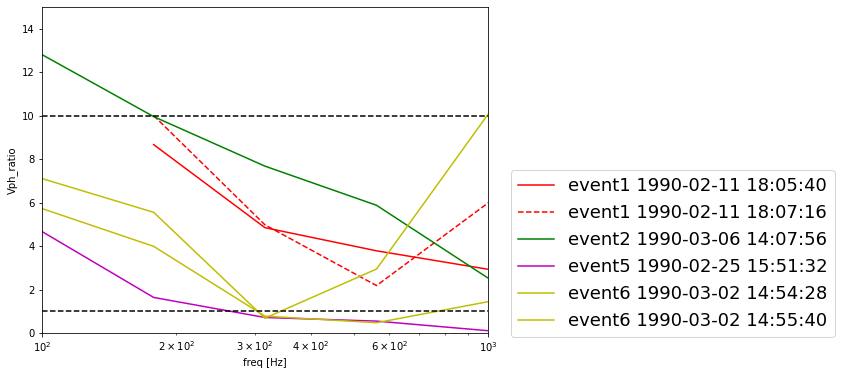

In [6]:

Vph_ratio = np.array(Vph_obs)/np.array(Vph_dr)
colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(8, 6))
plt.plot(freq_range, Vph_ratio[0], label='event1' + ' ' + event_time_list[0][0], color=colorlist[0])
plt.plot(freq_range, Vph_ratio[1], label='event1' + ' ' + event_time_list[0][1], color=colorlist[0], linestyle='dashed')
plt.plot(freq_range, Vph_ratio[2], label='event2' + ' ' + event_time_list[1][0], color=colorlist[1])
plt.plot(freq_range, Vph_ratio[8], label='event5' + ' ' + event_time_list[4][0], color=colorlist[4])
plt.plot(freq_range, Vph_ratio[10], label='event6' + ' ' + event_time_list[5][0], color=colorlist[5])
plt.plot(freq_range, Vph_ratio[11], label='event6' + ' ' + event_time_list[5][1], color=colorlist[5])
plt.xscale('log')
#plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('Vph_ratio')
plt.ylim(0,15)
plt.xlim(100, 1000)
plt.hlines(1, xmin=1e2, xmax=1e3, colors='k', linestyles='dashed')
plt.hlines(10, xmin=1e2, xmax=1e3, colors='k', linestyles='dashed')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='upper left', borderaxespad=0, fontsize=18)

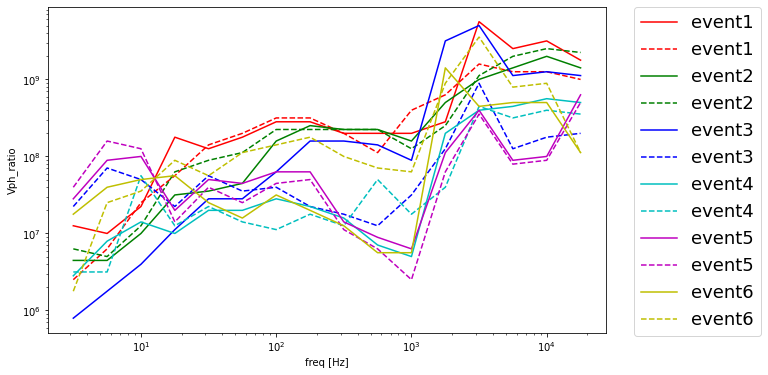

In [5]:
colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(freq_range, Vph_obs[2*i], label='event'+str(i+1), color=colorlist[i])
    plt.plot(freq_range, Vph_obs[2*i+1], label='event'+str(i+1), color=colorlist[i], linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('Vph_ratio')


plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

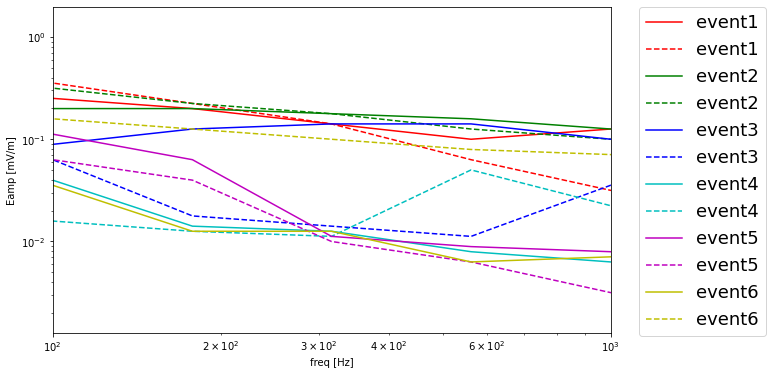

In [31]:

colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(freq_range, Eobs[2*i], label='event'+str(i+1), color=colorlist[i])
    plt.plot(freq_range, Eobs[2*i+1], label='event'+str(i+1), color=colorlist[i], linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('Eamp [mV/m]')
plt.xlim(100, 1000)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

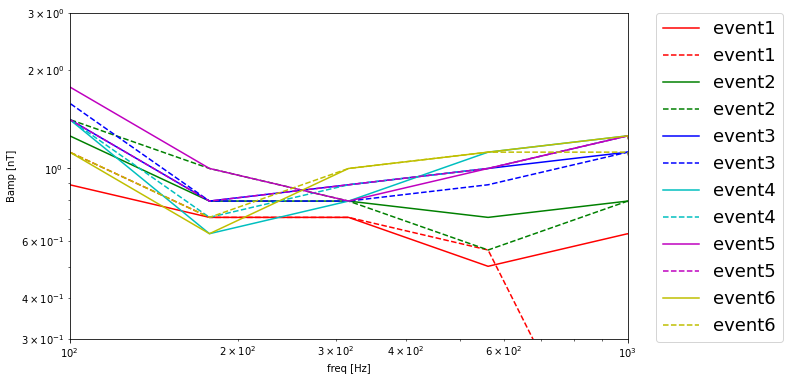

In [37]:
colorlist = ["r", "g", "b", "c", "m", "y"]
plt.figure(figsize=(10, 6))
for i in range(6):
    plt.plot(freq_range, Bobs[2*i], label='event'+str(i+1), color=colorlist[i])
    plt.plot(freq_range, Bobs[2*i+1], label='event'+str(i+1), color=colorlist[i], linestyle='dashed')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq [Hz]')
plt.ylabel('Bamp [nT]')
plt.xlim(100, 1000)
plt.ylim(0.3, 3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=18)

Ishigaya event plot

In [ ]:
import pyspedas, pytplot, load
from pytplot import get_data
import numpy as np
from calc_coldplasma_dispersion_relation import dispersion
import matplotlib.pyplot as plt

tranges = [['1990-02-11', '1990-02-12'],
           ['1990-03-06', '1990-03-07'],
           ['1990-02-17', '1990-02-18'],
           ['1990-02-25', '1990-02-26'],
           ['1990-02-25', '1990-02-26'],
           ['1990-03-02', '1990-03-03']]

event_times =  [pyspedas.time_double('1990-02-11 18:05:39'),
                pyspedas.time_double('1990-02-11 18:07:15'),
                pyspedas.time_double('1990-03-06 14:06:20'),
                pyspedas.time_double('1990-03-06 14:07:56'),
                pyspedas.time_double('1990-02-17 03:45:56'),
                pyspedas.time_double('1990-02-17 03:47:48'),
                pyspedas.time_double('1990-02-25 12:22:44'),
                pyspedas.time_double('1990-02-25 12:23:00'),
                pyspedas.time_double('1990-02-25 15:49:32'),
                pyspedas.time_double('1990-02-25 15:51:24'),
                pyspedas.time_double('1990-03-02 14:54:04'),
                pyspedas.time_double('1990-03-02 14:54:44')]

nes = [60e6, 71e6, 128e6, 225e6, 173e6, 47e6] 
ion_ratio =  [[0.46, 0.11, 0.43],
              [0.30, 0.06, 0.64],
              [0.24, 0.08, 0.68],
              [0.14, 0.10, 0.76],
              [0.32, 0.19, 0.56],
              [0.29, 0.19, 0.52]]

Vph_obs = []
Vph_dr  = []
Vph_ratio = []


for i in range(6):
    trange = tranges[i]
    event_time1 = pyspedas.time_double(event_times[2*i])
    event_time2 = pyspedas.time_double(event_times[2*i+1])

    load.mca(trange)
    load.orb(trange)
    tplot_names = ['Emax', 'Eave', 'Bmax', 'Bave']
    for j in range(4):
        tplot_variable = pytplot.get_data(tplot_names[j])
        tplot_variable_float = (tplot_variable.y).astype(float)
        np.place(tplot_variable_float, tplot_variable_float == 254, np.nan)
        tplot_variable_0dB = 1e-6 #mV or pT
        bandwidth = tplot_variable.v * 0.3
        tplot_variable_amplitude = (10**(tplot_variable_float/20)) * (tplot_variable_0dB)
        tplot_variable_power = (10**(tplot_variable_float/10)) * ((tplot_variable_0dB)**2)
        pytplot.store_data(tplot_names[j] +'_Amp', data={'x': tplot_variable.times, 'y': tplot_variable_amplitude, 'v': tplot_variable.v})
        pytplot.store_data(tplot_names[j] +'_Pwr', data={'x': tplot_variable.times, 'y': tplot_variable_power, 'v': tplot_variable.v})
    
    Eamp = pytplot.get_data('Emax_Amp')
    Epwr = pytplot.get_data('Emax_Pwr')

    Bamp = pytplot.get_data('Bmax_Amp')

    Times = Eamp.times
    #Time interpolate
    try:
        pyspedas.tinterpol('akb_ILAT', interp_to='Emax_Pwr', newname = 'ILAT')
    except:
        #with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        #       f.write(trange[0] + '\n')
        print('orbit file is not perfect')
        continue
    pyspedas.tinterpol('akb_MLAT', interp_to='Emax_Pwr', newname = 'MLAT')
    pyspedas.tinterpol('akb_Pass', interp_to='Emax_Pwr', newname = 'Pass', method = 'nearest')
    pyspedas.tinterpol('akb_ALT', interp_to='Emax_Pwr', newname = 'ALT')
    pyspedas.tinterpol('akb_MLT', interp_to='Emax_Pwr', newname = 'MLT', method = 'nearest')
    pytplot.tplot()
    

In [8]:
import numpy as np

a = np.array([0, 5, 2, np.nan, 5])
maxIndex = [i for i, x in enumerate(a) if x == np.nanmax(a)]
print(maxIndex)    # [1, 4]

[1, 4]


In [30]:
import pyspedas
import pytplot
from pytplot import get_data, store_data
import numpy as np
from load import mca, orb
import matplotlib.pyplot as plt

ILAT_min = 55
start_day_string = '1990-01-05'
start_day_time_double = pyspedas.time_double(start_day_string)
days = 180

seconds_per_day = 86400
day_list = []
for i in range(0, days+1):
    time_double = start_day_time_double + i * seconds_per_day
    day_list.append(pyspedas.time_string(time_double, fmt='%Y-%m-%d %H:%M:%S'))

Emax_pwr_10Hz_array = np.empty((0,0), float)
Emax_amp_176Hz_array = np.empty((0,0), float)
Emax_amp_316Hz_array = np.empty((0,0), float)
Emax_amp_562Hz_array = np.empty((0,0), float)

Bmax_amp_176Hz_array = np.empty((0,0), float)
Bmax_amp_316Hz_array = np.empty((0,0), float)
Bmax_amp_562Hz_array = np.empty((0,0), float)

E_to_B_176Hz_array = np.empty((0,0), float)
E_to_B_316Hz_array = np.empty((0,0), float)
E_to_B_562Hz_array = np.empty((0,0), float)

Emax_pwr_mean_fcH_fLH_array = np.empty((0,0), float)

for k in range(len(day_list)-1):
    
    trange = [day_list[k], day_list[k+1]]
    print(trange)
    try:
        mca(trange= trange)
    except Exception as e:
        print(e)
        continue
    try:
        orb(trange= trange)
    except Exception as e:
        print(e)
        #with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        #       f.write(trange[0] + '\n')
        
        #print('orbit file does not exists')
        continue
    
    tplot_names = pytplot.tplot_names(True)

    #dB to amplitude
    for i in range(4):
        tplot_variable = pytplot.get_data(tplot_names[i])
        tplot_variable_float = (tplot_variable.y).astype(float)
        np.place(tplot_variable_float, tplot_variable_float == 254, np.nan)
        tplot_variable_0dB = 1e-6 #mV or pT
        bandwidth = tplot_variable.v * 0.3
        tplot_variable_amplitude = (10**(tplot_variable_float/20)) * (tplot_variable_0dB)
        tplot_variable_power = (10**(tplot_variable_float/10)) * ((tplot_variable_0dB)**2) 
        pytplot.store_data(tplot_names[i] +'_Amp', data={'x': tplot_variable.times, 'y': tplot_variable_amplitude, 'v': tplot_variable.v})
        pytplot.store_data(tplot_names[i] +'_Pwr', data={'x': tplot_variable.times, 'y': tplot_variable_power, 'v': tplot_variable.v})
    
    #Time interpolate
    try:
        pyspedas.tinterpol('akb_ILAT', interp_to='Emax_Pwr', newname = 'ILAT')
    except:
        #with open('./akebono_orbit_error_day_list.txt', mode="a") as f:
        #       f.write(trange[0] + '\n')
        print('orbit file is not perfect')
        continue
    pyspedas.tinterpol('akb_MLAT', interp_to='Emax_Pwr', newname = 'MLAT')
    pyspedas.tinterpol('akb_Pass', interp_to='Emax_Pwr', newname = 'Pass', method = 'nearest')
    pyspedas.tinterpol('akb_ALT', interp_to='Emax_Pwr', newname = 'ALT')
    pyspedas.tinterpol('akb_MLT', interp_to='Emax_Pwr', newname = 'MLT', method = 'nearest')
    #Limit ILAT range
    Emax = get_data('Emax_Pwr')
    time = Emax.times
    ILAT = get_data('ILAT')
    ILAT = ILAT.y
    MLAT = get_data('MLAT')
    MLAT = MLAT.y
    MLT = get_data('MLT')
    MLT = MLT.y

    Emax_pwr = get_data('Emax_Pwr')
    Emax_amp = get_data('Emax_Amp')
    Bmax_amp = get_data('Bmax_Amp')
    
    E_to_B = Emax_amp.y/Bmax_amp.y *1e9
    
    index_tuple = np.where((ILAT > 55)&(10 < MLT)&(MLT < 14))
    Emax_in_cusp = Emax_pwr.y[index_tuple[0]]
    Eamp_in_cusp = Emax_amp.y[index_tuple[0]]
    Bamp_in_cusp = Bmax_amp.y[index_tuple[0]]
    
    E_to_B_in_cusp = E_to_B[index_tuple[0]]
            
    Emax_10Hz = Emax_in_cusp.T[2]
    Eamp_176Hz_562Hz = Eamp_in_cusp.T[7:10]
    Bamp_176Hz_562Hz = Bamp_in_cusp.T[7:10]
    E_to_B_176Hz_562Hz = E_to_B_in_cusp.T[7:10]
    
    Index_over_th = [i for i, Emax_10Hz_var in enumerate(Emax_10Hz) if Emax_10Hz_var > 0.1]
    Emax_10Hz_over_th = Emax_10Hz[Index_over_th]
    
    Emax_176Hz = Eamp_176Hz_562Hz[0, Index_over_th]
    Emax_316Hz = Eamp_176Hz_562Hz[1, Index_over_th]
    Emax_562Hz = Eamp_176Hz_562Hz[2, Index_over_th]
    
    Bmax_176Hz = Bamp_176Hz_562Hz[0, Index_over_th]
    Bmax_316Hz = Bamp_176Hz_562Hz[1, Index_over_th]
    Bmax_562Hz = Bamp_176Hz_562Hz[2, Index_over_th]
    
    E_to_B_176Hz = E_to_B_176Hz_562Hz[0, Index_over_th]
    E_to_B_316Hz = E_to_B_176Hz_562Hz[1, Index_over_th]
    E_to_B_562Hz = E_to_B_176Hz_562Hz[2, Index_over_th]
    
    #Emax_mean_fch_fLH = np.nanmean(Emax_176Hz_562Hz[:, Index_over_th], axis = 0)

    Emax_pwr_10Hz_array = np.append(Emax_pwr_10Hz_array, Emax_10Hz_over_th)
    Emax_amp_176Hz_array = np.append(Emax_amp_176Hz_array, Emax_176Hz)
    Emax_amp_316Hz_array = np.append(Emax_amp_316Hz_array, Emax_316Hz)
    Emax_amp_562Hz_array = np.append(Emax_amp_562Hz_array, Emax_562Hz)
    
    Bmax_amp_176Hz_array = np.append(Bmax_amp_176Hz_array, Bmax_176Hz)
    Bmax_amp_316Hz_array = np.append(Bmax_amp_316Hz_array, Bmax_316Hz)
    Bmax_amp_562Hz_array = np.append(Bmax_amp_562Hz_array, Bmax_562Hz)
    
    E_to_B_176Hz_array = np.append(E_to_B_176Hz_array, E_to_B_176Hz)
    E_to_B_316Hz_array = np.append(E_to_B_316Hz_array, E_to_B_316Hz)
    E_to_B_562Hz_array = np.append(E_to_B_562Hz_array, E_to_B_562Hz)
    
    #Emax_pwr_mean_fcH_fLH_array = np.append(Emax_pwr_mean_fcH_fLH_array, Emax_mean_fch_fLH)


['1990-01-05 00:00:00', '1990-01-06 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-06 00:00:00', '1990-01-07 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-07 00:00:00', '1990-01-08 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-08 00:00:00', '1990-01-09 00:00:00']
tinterpol (linear) was applied to: ILAT
tinterpol (linear) was applied to: MLAT
tinterpol (nearest) was applied to: Pass
tinterpol (linear) was applied to: ALT
tinterpol (nearest) was applied to: MLT
['1990-01-09

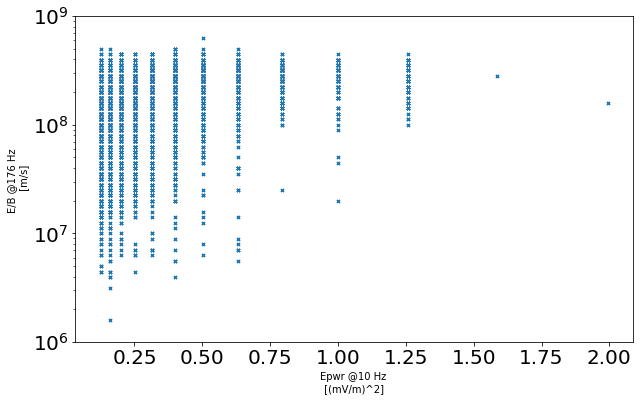

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('E/B @176 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

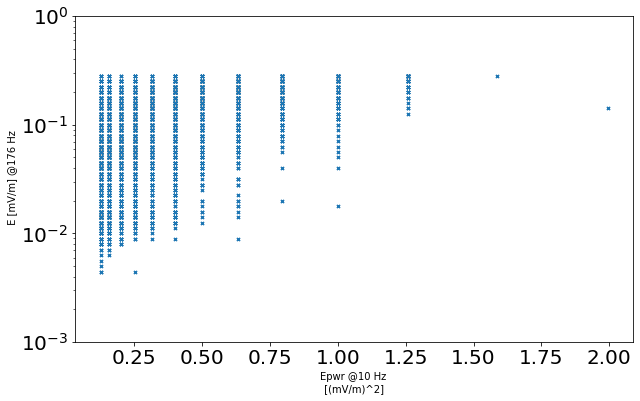

In [21]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_176Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @176 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

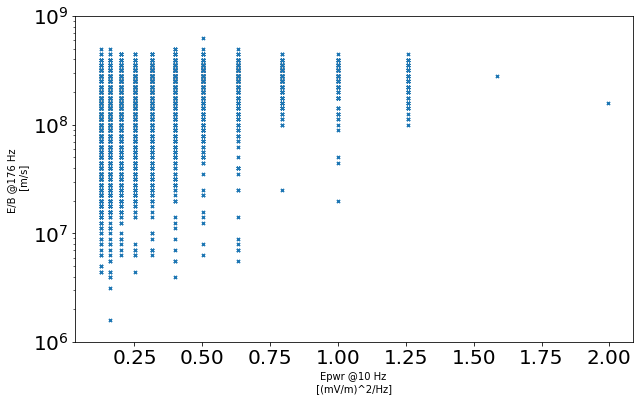

In [22]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @176 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output10')
plt.show()

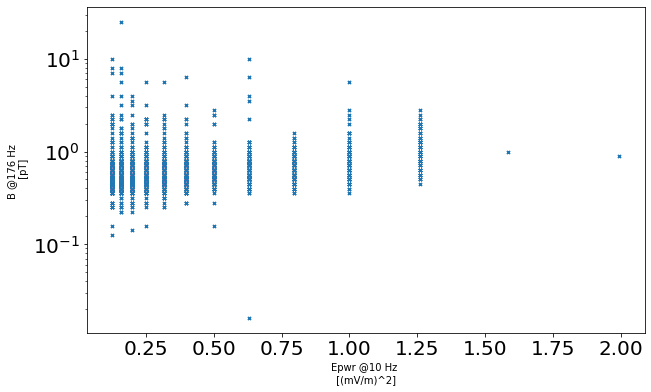

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_176Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @176 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

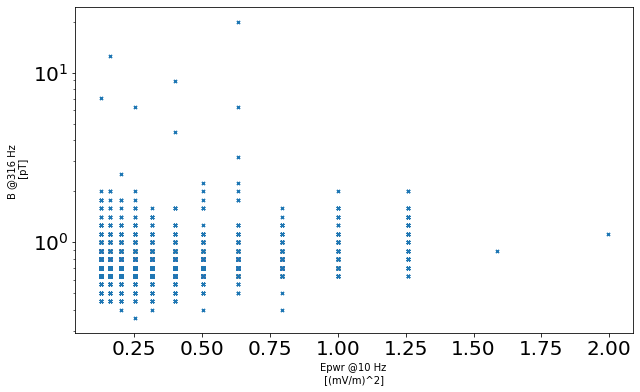

In [34]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_316Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @316 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

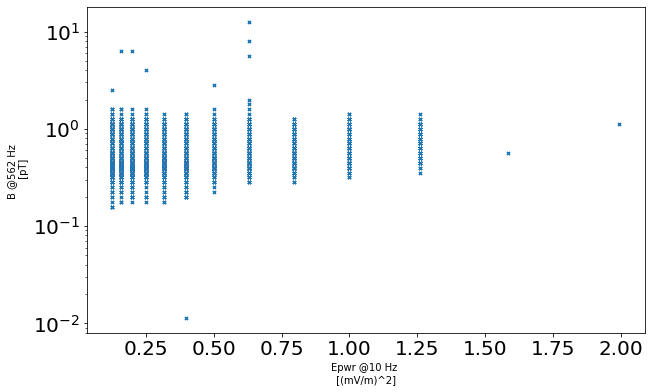

In [35]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Bmax_amp_562Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel('B @562 Hz \n [pT]')
#plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.show()

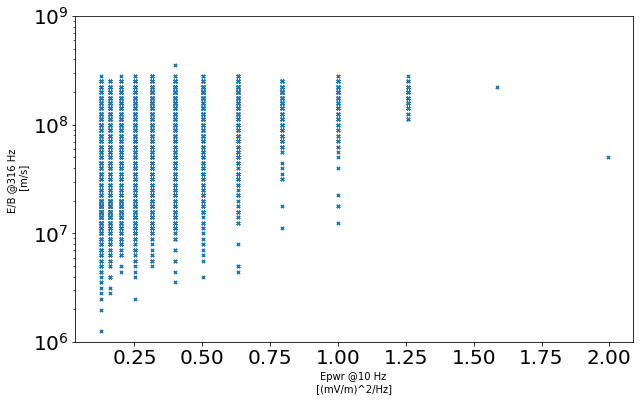

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_316Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @316 Hz \n [m/s]')
plt.ylim(1e6, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output20')
plt.show()

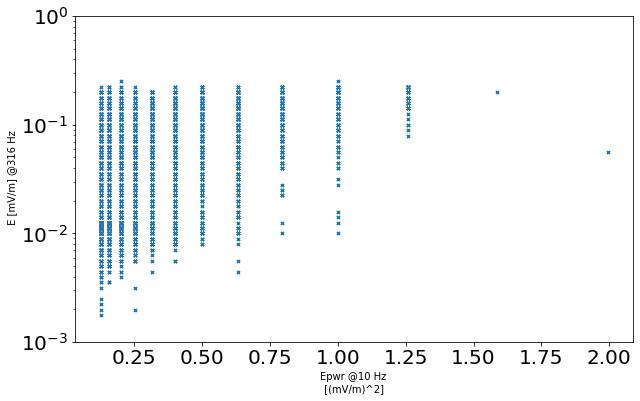

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_316Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @316 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

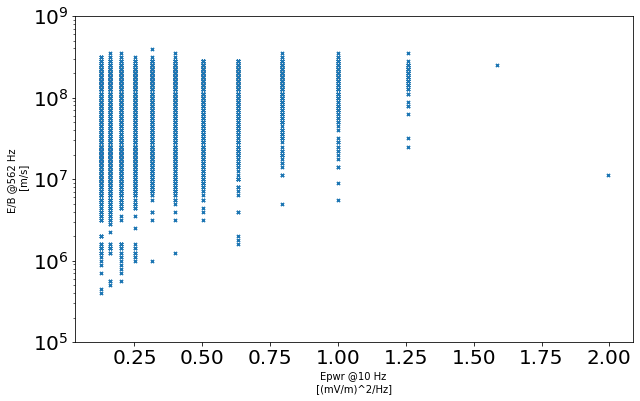

In [25]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, E_to_B_562Hz_array, s=10, marker='x')
plt.xlabel('Epwr @10 Hz \n [(mV/m)^2/Hz] ')
plt.ylabel('E/B @562 Hz \n [m/s]')
plt.ylim(1e5, 1e9)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)
plt.savefig('output30')
plt.show()

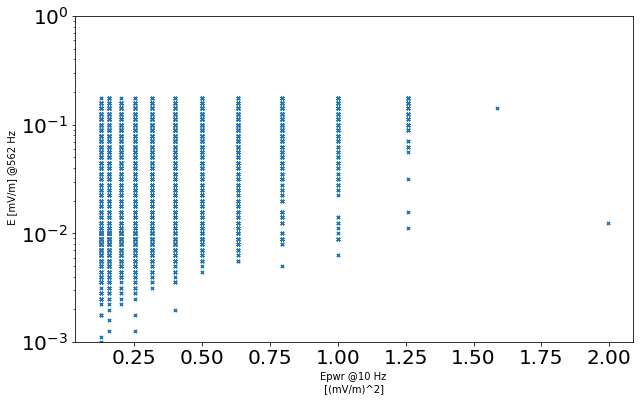

In [29]:
plt.figure(figsize=(10, 6))
plt.scatter(Emax_pwr_10Hz_array, Emax_amp_562Hz_array, s=10, marker='x')

plt.xlabel('Epwr @10 Hz \n [(mV/m)^2] ')
plt.ylabel(' E [mV/m] @562 Hz')
plt.ylim(1e-3, 1)
plt.yscale('log')
plt.xticks(fontsize =20)
plt.yticks(fontsize =20)

plt.show()

# An estimation of the doppler shift effect  



In [6]:
import numpy as np
Ne = np.array([60, 71, 128, 225, 173, 47])*1e6
fpe = 9*np.sqrt(Ne)*1e3
H_number_ratio = np.array([0.46, 0.30, 0.24, 0.14, 0.32, 0.29])
H_vth = np.array([29.4, 33.9, 23.2, 24.2, 30.3, 57.7])*1e3
O_number_ratio = np.array([0.43, 0.64, 0.68, 0.76, 0.56, 0.52])
O_vth = np.array([6.09, 7.33, 6.86, 4.78, 7.07, 14.1])*1e3
vth = H_number_ratio*H_vth + O_number_ratio*O_vth
fcO = np.array([8.53, 5.62, 5.26, 6.39, 6.28, 5.76])
electron_skin_depth = 3e8 / (2*np.pi*fpe)
ion_gyro_radii = vth/(2*np.pi*fcO)

print('fpe:', fpe)
print(vth)
print('electron skin depth:',electron_skin_depth)
print('ion gyro radius:', ion_gyro_radii)

fpe: [6.97137002e+07 7.58353480e+07 1.01823376e+08 1.35000000e+08
 1.18376518e+08 6.17008914e+07]
[16142.7 14861.2 10232.8  7020.8 13655.2 24065. ]
electron skin depth: [0.68489383 0.62960722 0.46891475 0.35367765 0.40334421 0.77383781]
ion gyro radius: [301.19466587 420.86004275 309.61990526 174.86620101 346.06569728
 664.94161554]


In [7]:
help(vth)

Help on ndarray object:

class ndarray(builtins.object)
 |  ndarray(shape, dtype=float, buffer=None, offset=0,
 |          strides=None, order=None)
 |  
 |  An array object represents a multidimensional, homogeneous array
 |  of fixed-size items.  An associated data-type object describes the
 |  format of each element in the array (its byte-order, how many bytes it
 |  occupies in memory, whether it is an integer, a floating point number,
 |  or something else, etc.)
 |  
 |  Arrays should be constructed using `array`, `zeros` or `empty` (refer
 |  to the See Also section below).  The parameters given here refer to
 |  a low-level method (`ndarray(...)`) for instantiating an array.
 |  
 |  For more information, refer to the `numpy` module and examine the
 |  methods and attributes of an array.
 |  
 |  Parameters
 |  ----------
 |  (for the __new__ method; see Notes below)
 |  
 |  shape : tuple of ints
 |      Shape of created array.
 |  dtype : data-type, optional
 |      Any objec